# Helix Simulation Tutorial for UAMMD-structured

## Introduction
This notebook demonstrates how to create and run a simulation of polymer chains using the Worm-Like Chain (WLC) model in UAMMD-structured. The WLC model is commonly used to describe semi-flexible polymers. We'll walk through the process step-by-step, explaining each part of the simulation setup in detail.

# Free Helix Simulation

## Libraries and Functions

First, let's import the necessary libraries:

In [12]:
import os
import numpy as np
import pyUAMMD
import matplotlib.pyplot as plt

### Specific functions

Below are utility functions for generating helical coordinates and calculating dihedral angles. These functions are defined here for use during the simulation setup.

In [13]:

def make_helix(N, radius=1.0, pitch=3.0, loops=3):
    """
    Generates 3D multiblob helix coordinates
    
    Parameters:
    -----------
    N : int
        Total number of particles
    radius : float
        Helix radius
    pitch : float
        pitch (distance between loops).
    loops : int
        Number of complete loops

    Returns:
    --------
    coords : np.ndarray (N,3)
        [x,y,z] particles' coordinates
    """
    assert N > 0, "Particle number must be positive"
    assert int(N/loops) == N/loops, "Number of particles mus be multiple of number of loops"
    
    delta_theta = 2 * np.pi * loops / N   # Angular separation between particles (measured from helix axis)
    thetas = np.arange(N) * delta_theta   # Angles array

    # Helix particles' coordinates
    x = radius * np.cos(thetas)
    y = radius * np.sin(thetas)
    z = (pitch / (2*np.pi)) * thetas

    return np.column_stack((x, y, z))


def dihedral(p0,p1,p2,p3):
    """
    Dihedral angle constructor between 4 particles
    
    Parameters:
    -----------
    pi: particle i positions

    Returns:
    --------
    angle : dihedral angle
    """
    b0 = p1 - p0
    b1 = p2 - p1
    b2 = p3 - p2

    n1 = np.cross(b0, b1)
    n2 = np.cross(b1, b2)

    n1_norm = n1 / np.linalg.norm(n1)
    n2_norm = n2 / np.linalg.norm(n2)
    m1 = np.cross(n1_norm, b1/np.linalg.norm(b1))
    x = np.dot(n1_norm, n2_norm)
    y = np.dot(m1, n2_norm)
    angle = np.atan2(y, x)

    return angle

## Parameters

Define the key parameters for our Helix simulation:

### Helix Parameters

First, we characterize our helix

In [14]:
# Helix geometry
nBeadsPerLoop = 15
loops = 3
nBeads = nBeadsPerLoop * loops
pitch = 8
sigma = 1.0 # Bead diameter (and bond length)
helix_coords = make_helix(N=nBeads, radius=2*sigma, pitch=pitch, loops=loops)
helix_coords -= np.mean(helix_coords, axis=0) # Center the helix coords


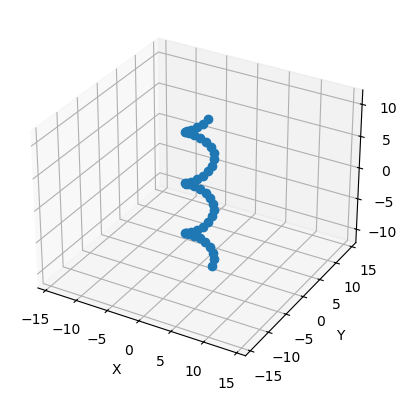

In [15]:

# 3D plot of the helix
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(helix_coords[:,0], helix_coords[:,1], helix_coords[:,2], marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
plt.show()


### Simulation Parameters
Parameters related with the simulation development

In [16]:

L = 4*np.max(np.abs(helix_coords)) + 2.0*sigma  # Box size

timeStep = 0.01 
frictionConstant = 3*np.pi
nSteps = 30000
nStepsInfo = 3000  # Frequency of info output
nStepsOutput = 100 # Frequency of trajectory output

T = 0.01    # Temperature
Kb = 100.0  # Pair bond strength
Ka = 100.0  # Angle strength (bending rigidity)
Kc = 100.0    # Dihedral strength


## Creating the Simulation

Now, let's create our UAMMD-Structured simulation and set up its various components.
For that, we will use a `pyUAMMD` simulation object

In [17]:
# Initialize the simulation object
simulation = pyUAMMD.simulation()

# Set up the system information (give it a name)
simulation["system"] = {
    "info": {
        "type": ["Simulation", "Information"],
        "parameters": {"name": "Free Helix Simulation"}
    }
}

The `pyUAMMD` simulation object is a Python dictionary, allowing you to access and modify its components using standard dictionary operations. For example, you can print, retrieve or update simulation entities directly by referencing their keys.

In [18]:


print("Simulation named:", simulation["system"]["info"]["parameters"]["name"])


Simulation named: Free Helix Simulation


## Global
Here we will define overall aspects of the simulation

In [19]:


# Define global parameters
simulation["global"] = {
    # Set the unit system (in this case, we're using reduced units)
    "units": {"type": ["Units", "None"]},

    # Define particle types
    "types": {
        "type": ["Types", "Basic"],
        "labels": ["name", "mass", "radius", "charge"],
        "data": [["A", 1.0, sigma/2.0, 0.0]]
    },

    # Set the ensemble (NVT: constant Number of particles, Volume, and Temperature)
    "ensemble": {
        "type": ["Ensemble", "NVT"],
        "labels": ["box", "temperature"],
        "data": [[[L, L, L], T]]
    }
}

## Integrator

We set a Langevin integrator to evolve the system, specifying both the time step and friction constant for the dynamics. Additionally, the integration schedule determines the total number of simulation steps to be executed.

In [20]:
# Set up the integrator (Langevin dynamics)
simulation["integrator"] = {
    "bbk": {
        "type": ["Langevin", "BBK"],
        "parameters": {
            "timeStep": timeStep,
            "frictionConstant": frictionConstant
        }
    },
    # Define the integration schedule
    "schedule": {
        "type": ["Schedule", "Integrator"],
        "labels": ["order", "integrator", "steps"],
        "data": [[1, "bbk", nSteps]]
    }
}

## State and Topology

We´ll set the state positions and multiple bonds of the helix

### Initialization

We initialize the state and topology entities of the simulation. 

In [21]:
simulation["state"] = {
    "labels": ["id", "position"],
    "data": []
}

simulation["topology"] = {
    "structure": {
        "labels": ["id", "type", "modelId"],
        "data": []
    }
}

We modify the simulation dictionary by referencing its keys to establish particle positions and define the topology structure. In this setup, all particles are assigned to a single group representing the helix.

In [22]:

particleId = 0
for j in range(int(nBeads)):
    # Place beads along the z-axis, centered at the origin
    simulation["state"]["data"].append([particleId, [helix_coords[j, 0], helix_coords[j, 1], helix_coords[j, 2]]])
    simulation["topology"]["structure"]["data"].append([particleId, "A", j])
    particleId += 1

### Initialize bonds

We create a `forceField` section in topology entity with different bond entries

In [23]:
simulation["topology"]["forceField"] = {}

# Harmonic bonds
simulation["topology"]["forceField"]["bonds"] = {
    "type": ["Bond2", "Harmonic"],
    "parameters": {},
    "labels": ["id_i", "id_j", "K", "r0"],
    "data": []
}

# Angular bonds
simulation["topology"]["forceField"]["angles"] = {
    "type": ["Bond3", "KratkyPorod"],
    "parameters": {},
    "labels": ["id_i", "id_j", "id_k", "K"],
    "data": []
}

# Dihedral_bonds
dihedral_angle = dihedral(helix_coords[0], helix_coords[1], helix_coords[2], helix_coords[3])
simulation["topology"]["forceField"]["dihedrals"] = {
    "type": ["Bond4", "DihedralCommon_n_K_phi0"],
    "parameters": {"n": 1,
                   "K": Kc*0,
                   "phi0": dihedral_angle},
    "labels": ["id_i", "id_j", "id_k", "id_l"],
    "data": []
}

### Bonds definition

In [24]:
particleId = 0
r0 = np.linalg.norm(np.diff(helix_coords, axis=0), axis=1)  # N-1 valores
for j in range(int(nBeads) - 1):
    simulation["topology"]["forceField"]["bonds"]["data"].append([particleId, particleId + 1, Kb, r0[j]])
    particleId += 1

particleId = 0
r_pitch = np.linalg.norm((helix_coords[0]-helix_coords[nBeadsPerLoop]), axis=0)
for j in range(int(nBeads) - nBeadsPerLoop):
    simulation["topology"]["forceField"]["bonds"]["data"].append([particleId, particleId + nBeadsPerLoop, Kb, r_pitch])
    particleId += 1

particleId = 0
for j in range(int(nBeads) - 2):
    simulation["topology"]["forceField"]["angles"]["data"].append([particleId, particleId + 1, particleId + 2, Ka])
    particleId += 1

particleId = 0
for j in range(int(nBeads) - 2*nBeadsPerLoop):
    simulation["topology"]["forceField"]["angles"]["data"].append([particleId, particleId + nBeadsPerLoop, particleId + 2*nBeadsPerLoop, Ka])
    particleId += 1

particleId = 0
for j in range(int(nBeads) - 3):
    simulation["topology"]["forceField"]["dihedrals"]["data"].append([particleId, particleId + 1, particleId + 2, particleId + 3])
    particleId += 1

## Simulation Steps

We define operations to perform during the simulation. In this example, some screen info logs and trajectory outputs (xyz format)

In [25]:
simulation["simulationStep"] = {
    # Output simulation information periodically
    "info": {
        "type": ["UtilsStep", "InfoStep"],
        "parameters": {"intervalStep": nStepsInfo}
    },
    # Save trajectory data periodically
    "output": {
        "type": ["WriteStep", "WriteStep"],
        "parameters": {
            "intervalStep": nStepsOutput,
            "outputFilePath": "output",
            "outputFormat": "xyz"
        }
    }
}

## Simulation writing

We generate `simulation.json` file. After that we can use `UAMMDlauncher simulation.json` command in Terminal[link text](https://) to carry on the simulation and generate the specified output

In [26]:
print()
print("Writing simulation file...")
simulation.write("simulation.json")
print("Simulation file created successfully!")
print()

10/09/2025 16:13:46 - pyUAMMD - WARNING - Writing with legacy 



Writing simulation file...
Simulation file created successfully!



## Running the Simulation

To run the simulation, you would typically use the UAMMD-structured executable with the generated JSON file.

In [27]:
!UAMMDlauncher simulation.json

[MESSAGE] [Input] File simulation.json loaded
[WARNING] [Simulation] Simulation has no backup, will not restart if it fails.
[MESSAGE] ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
[MESSAGE] ╻ ╻┏━┓┏┳┓┏┳┓╺┳┓
[MESSAGE] ┃ ┃┣━┫┃┃┃┃┃┃ ┃┃ Version: 2.5
[MESSAGE] ┗━┛╹ ╹╹ ╹╹ ╹╺┻┛
[MESSAGE] Compiled at: May 30 2025 09:39:25
[MESSAGE] Compiled in double precision mode
[MESSAGE] Computation started at Wed Sep 10 16:14:11 2025

[MESSAGE] [System] CUDA initialized
[MESSAGE] [System] Using device: NVIDIA GeForce RTX 3080 with id: 0
[MESSAGE] [System] Compute capability of the device: 8.6
[MESSAGE] ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ 
[MESSAGE] [Input] File simulation.json loaded
[MESSAGE] [ExtendedSystem] (system) Name: Free Helix Simulation
[MESSAGE] [ExtendedSystem] (system) Seed: 1757513651940133924
[MESSAGE] [GlobalDataBase] Fundamental not specified, using default fundamental, "Time"
[WARNING] [Time] No timeStep specified, using 0.0 as default.
[MESSAGE] [Ba

In [ ]:
# Create an animation of the output.xyz created
!conda install nglview -y
import nglview as nv
view = nv.show_file("output.xyz")
view.clear_representations()
view.add_ball_and_stick()
view.center()
view


Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/joan/miniforge3/envs/uammd-structured

  added / updated specs:
    - nglview


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anyio-4.10.0               |     pyhe01879c_0         132 KB  conda-forge
    argon2-cffi-25.1.0         |     pyhd8ed1ab_0          18 KB  conda-forge
    argon2-cffi-bindings-25.1.0|  py312h4c3975b_0          35 KB  conda-forge
    arrow-1.3.0                |     pyhd8ed1ab_1          98 KB  conda-forge
    async-lru-2.0.5            |     pyh29332c3_0          17 KB  conda-forge
    beautifulsoup4-4.13.5      |     pyha770c72_0          86 KB  conda-forge
    bleach-6.2.0               |     pyh29332c3_4         138 KB  conda-forge
    bleach-with-css-6.2.0      |       h82add2a_4           4 KB  conda-forge
    cached-property-1.5.2      

ModuleNotFoundError: No module named 'nglview'

In [9]:
# # Set up harmonic bonds
# simulation["topology"]["forceField"]["surface"] = {
#     "type":["Surface","SurfaceWCAType1"],
#     "parameters":{
#         "surfacePosition": -L/2 + 5.0*sigma,
#     },
#     "labels":["name", "epsilon", "sigma"],
#     "data":[
#         ["A", 1.0, 1.0]
#   ]
# }
simulation["integrator"]["bbk"] = {
    "type":["FluctuatingHydrodynamics","IncompressibleInertialCoupling"],
    "parameters":{
    "timeStep": timeStep,
    "viscosity": 1.0,
    "density": 1.0,
    "hydrodynamicRadius": 0.5*sigma,
    "sumThermalDrift": False,
    "removeTotalMomentum": True
    }
}
# Set up harmonic bonds
simulation["topology"]["forceField"]["gravity"] = {
    "type": ["External", "ConstantForce"],
    "parameters": {"constantForce": [0.0, 0.0, -1]}
}

simulation["simulationStep"] = {
    # Output simulation information periodically
    "info": {
        "type": ["UtilsStep", "InfoStep"],
        "parameters": {"intervalStep": nStepsInfo}
    },
    # Save trajectory data periodically
    "output": {
        "type": ["WriteStep", "WriteStep"],
        "parameters": {
            "intervalStep": nStepsOutput,
            "outputFilePath": "gravity_output",
            "outputFormat": "sp",
            "pbc": False
        }
    }
}

In [10]:
simulation.write("simulation_gravity.json")
simulation.run()

08/09/2025 12:54:49 - pyUAMMD - WARNING - Writing with legacy 
[WARNING] UAMMD-structured Python wrapper is not compatible with UAMMD-structured self restarting mechanism
[MESSAGE] ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
[MESSAGE] ╻ ╻┏━┓┏┳┓┏┳┓╺┳┓
[MESSAGE] ┃ ┃┣━┫┃┃┃┃┃┃ ┃┃ Version: 2.5
[MESSAGE] ┗━┛╹ ╹╹ ╹╹ ╹╺┻┛
[MESSAGE] Compiled at: May 30 2025 09:48:24
[MESSAGE] Compiled in double precision mode
[MESSAGE] Computation started at Mon Sep  8 12:54:49 2025

[MESSAGE] [System] CUDA initialized
[MESSAGE] [System] Using device: NVIDIA GeForce RTX 4070 Ti with id: 0
[MESSAGE] [System] Compute capability of the device: 8.9
[MESSAGE] ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ ━ 
[MESSAGE] [ExtendedSystem] (system) Name: WormLikeChain
[MESSAGE] [ExtendedSystem] (system) Seed: 1757328890124187674
[MESSAGE] [GlobalDataBase] Fundamental not specified, using default fundamental, "Time"
[WARNING] [Time] No timeStep specified, using 0.0 as default.
[MESSAGE] [Basic] 

## Conclusion

This tutorial demonstrated how to set up and prepare a simulation of Worm-Like Chains using UAMMD-structured. We covered:
1. Defining simulation parameters, including polymer-specific parameters
3. Creating the simulation object
4. Setting up the system, global parameters, and integrator
5. Initializing particle positions and topology for multiple polymer chains
6. Configuring the simulation topology and force field, including bonded and angle interactions
7. Setting up simulation steps for output
8. Writing the simulation file
9. Running the simulation

Next steps could include:
- Analyzing the output trajectory
- Visualizing the polymer chains
- Calculating polymer properties such as end-to-end distance or radius of gyration
- Modifying the simulation parameters to explore different polymer lengths, stiffnesses, or environmental conditions